In [208]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

We an advertisement company hired by the City of Chicago to create a series of safe driving Public Safety Anncouncements for young adults. 

These ads will run on social media as well as being posted near high schools and college campuses. 

In order to figure out what ads will be the most effective, we are examining the causes of accidents for two age ranges: 15-18 year olds and 18-22 year olds. Once we determine the most common causes of accidents, we will be able to tailor our ads for the city, and hopefully reduce accidents for our target group.

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

add results

# Data Import and Cleaning 

In [209]:
#df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
#df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
#df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [210]:
#Random sample of vehicles 
#df_accidents = df_vehicles.sample(n=350000, random_state=42)

In [211]:
#Then we can add the crash report data 
#df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [212]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
#df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [213]:
#df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [214]:
df_accidents = pd.read_csv("data/Final_Data.csv")

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# ^^^^^ DELETE BEFORE SUBMISSION

In [215]:
#Sets all column names to lowercase
df_accidents.columns = [column.lower() for column in df_accidents.columns]

In [216]:
#have the crash date as a datetime object. 
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'], format="%m/%d/%Y %I:%M:%S %p")

## Drop Unnessisary Columns

In [217]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

In [218]:
cols_to_drop = [
#remove unnessisary id columns now the data is joined 
'vehicle_id', 'crash_record_id', 'crash_unit_id',
#drop LAT and LONG (we have location)
'latitude', 'longitude',
#...also drop streets and directions. 
'street_no', 'street_direction', 'street_name', 'travel_direction', 
#police specific 
'beat_of_occurrence', 
#every data entry is in chicago 
'city', 'zipcode', 
#covered by MOST_SEVERE_INJURY
'injury_classification',
#many NAN
'injuries_unknown'
]

df_accidents.drop(columns=cols_to_drop, inplace=True)


In [219]:
df_accidents = df_accidents.loc[(df_accidents['age'] > 14) & (df_accidents['age'] < 23) & 
                                (df_accidents['person_type'] == 'DRIVER') & (df_accidents['state'] == 'IL')]
df_accidents
df_accidents = df_accidents.loc[df_accidents['vehicle_year'].notna()]

In [220]:
#map the weather to a number 

def weather_code(weather):
    """
    0 - Unknown, Clear, Clouds
    1 - Rain, Snow, Freezing Rain/Drizzle, Sleet/Hail, Blowing Snow, Fog/Smoke/Haze, Blowing Sand/Soil/Dirt
    """
    #unserious weather condition
    if weather in ['CLEAR', 'CLOUDY/OVERCAST']:
        return 0
    #serious weather condition
    elif weather in ['RAIN', 'SNOW', 'FREEZING RAIN/DRIZZLE', 'SLEET/HAIL', 'BLOWING SNOW', 'FOG/SMOKE/HAZE', 
                     'BLOWING SAND/SOIL/DIRT']:
        return 1
    #unknown weather condition
    return 0
    
df_accidents['weather_condition'] = df_accidents['weather_condition'].map(weather_code)

In [221]:
#map the lighting conditions
def lighting(lighting_condition):
    """
    0 - Unknown, darkness (lighted road), Daylight
    1 - Darkness, Dusk, Dawn
    """
    #bad lighting conditions
    if lighting_condition in ['DARKNESS', 'DUSK', 'DAWN']:
        return 1
    #good/unknown lighting conditions
    return 0
df_accidents['lighting_condition'] = df_accidents['lighting_condition'].map(lighting)
df_accidents['lighting_condition'].value_counts()

0    17089
1     1677
Name: lighting_condition, dtype: int64

In [222]:
df_accidents['most_severe_injury'].value_counts()

NO INDICATION OF INJURY     15204
NONINCAPACITATING INJURY     2054
REPORTED, NOT EVIDENT        1063
INCAPACITATING INJURY         420
FATAL                          25
Name: most_severe_injury, dtype: int64

In [177]:
#map the injuries to a number 

def injury_severity(severity):
    """
    Injuries are categorized on a scale of 0 to 1
    0 - No Indication of Injury 
    0 - REPORTED, NOT EVIDENT 
    0 - Nonincapacitating Injury 
    1 - incapacitating Injury 
    1 - Fatal Injury 
    """
    #Serious Injury
    if severity in ['INCAPACITATING INJURY', 'FATAL']:
        return 1
    #No Injury or Minor Injury
    else:
        return 0
    

df_accidents['serious_injury'] = df_accidents['most_severe_injury'].map(injury_severity)

In [178]:
#map the crash severity to a number 

def crash_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['crash_type'] = df_accidents['crash_type'].map(crash_severity)

In [179]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
'injuries_reported_not_evident', 'injuries_no_indication'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [180]:
df_accidents['prim_contributory_cause'].unique()

array(['UNABLE TO DETERMINE', 'FOLLOWING TOO CLOSELY',
       'IMPROPER TURNING/NO SIGNAL', 'DISTRACTION - FROM INSIDE VEHICLE',
       'IMPROPER OVERTAKING/PASSING', 'FAILING TO YIELD RIGHT-OF-WAY',
       'FAILING TO REDUCE SPEED TO AVOID CRASH', 'IMPROPER LANE USAGE',
       'ANIMAL', 'NOT APPLICABLE', 'DISREGARDING TRAFFIC SIGNALS',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 'IMPROPER BACKING',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'EQUIPMENT - VEHICLE CONDITION',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'WEATHER', 'PHYSICAL CONDITION OF DRIVER',
       'CELL PHONE USE OTHER THAN TEXTING',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'DISREGARDING STOP SIGN',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'EXCEEDING AUTHORIZED SPEED LIMIT',
       'DRIVING ON WRONG SIDE/WRONG WAY', 'DISREGARDING ROAD MARKINGS',
       'OBSTRUCTED CROSSWALKS', 'EXCE

In [181]:
# Categorize primary contributory cause into different categories

def bin_cause(cause):
    
    if cause == 'UNABLE TO DETERMINE':
        return 0
    
    elif cause in ['DISREGARDING TRAFFIC SIGNALS', 'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY', 
                   'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO YIELD RIGHT-OF-WAY',
                   'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
                   'FAILING TO REDUCE SPEED TO AVOID CRASH', 
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
                   'IMPROPER BACKING', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
                   'EXCEEDING AUTHORIZED SPEED LIMIT', 'DRIVING ON WRONG SIDE/WRONG WAY',
                   'DISREGARDING ROAD MARKINGS', 'EXCEEDING SAFE SPEED FOR CONDITIONS', 'DISREGARDING YIELD SIGN',
                   'TURNING RIGHT ON RED', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'PASSING STOPPED SCHOOL BUS',
                   'RELATED TO BUS STOP', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']:
        return 1
                 
    elif cause in ['UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)']:
        return 2
    
    elif cause in ['DISTRACTION - FROM INSIDE VEHICLE', 'DISTRACTION - FROM OUTSIDE VEHICLE', 
                   'CELL PHONE USE OTHER THAN TEXTING', 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
                   'TEXTING']:
        return 3     
    
 #we may want to look into NOT APPLICABLE to see what that could mean                
    elif cause in ['NOT APPLICABLE', 'PHYSICAL CONDITION OF DRIVER', 
                 'EQUIPMENT - VEHICLE CONDITION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
                 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
                 'OBSTRUCTED CROSSWALKS', 'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER', 'ANIMAL']:
        return 4
    else:
        return 0
    
df_accidents['prim_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
df_accidents['sec_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
    

In [182]:
df_accidents['prim_contributory_cause'].isna().value_counts()

False    18766
Name: prim_contributory_cause, dtype: int64

In [183]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18766 entries, 44 to 378284
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unnamed: 0               18766 non-null  int64         
 1   crash_date               18766 non-null  datetime64[ns]
 2   unit_no                  18766 non-null  int64         
 3   unit_type                18766 non-null  object        
 4   make                     18765 non-null  object        
 5   model                    18762 non-null  object        
 6   lic_plate_state          18223 non-null  object        
 7   vehicle_year             18766 non-null  float64       
 8   vehicle_defect           18766 non-null  object        
 9   vehicle_type             18766 non-null  object        
 10  vehicle_use              18766 non-null  object        
 11  maneuver                 18766 non-null  object        
 12  occupant_cnt             18766

# Mapping BAC and Vehicle defects

In [184]:
def vehicle_defect_clf(defect):
    ''' 
    0 = No / Unknown defect

    1 = Has a defect 
    '''
    if defect in ['NONE', 'UNKNOWN']:
        return 0
    return 1

df_accidents['vehicle_defect'] = df_accidents['vehicle_defect'].map(vehicle_defect_clf)

In [185]:
df_accidents['sec_contributory_cause'].value_counts()

0    18766
Name: sec_contributory_cause, dtype: int64

## Examine Correlations

In [186]:
#matrix = df_accidents.corr()
#print(matrix)

                         unnamed: 0   unit_no  vehicle_year  vehicle_defect  \
unnamed: 0                 1.000000 -0.030351      0.000073        0.006591   
unit_no                   -0.030351  1.000000      0.026196       -0.068996   
vehicle_year               0.000073  0.026196      1.000000        0.001085   
vehicle_defect             0.006591 -0.068996      0.001085        1.000000   
occupant_cnt              -0.014501  0.049222      0.001302       -0.007074   
posted_speed_limit        -0.015691  0.047335      0.003955        0.006839   
weather_condition         -0.008608 -0.020038     -0.012835        0.004826   
lighting_condition         0.002715  0.014262     -0.006905       -0.004310   
crash_type                -0.028598 -0.040590     -0.004704        0.049832   
prim_contributory_cause   -0.008234 -0.057914     -0.008435        0.137208   
sec_contributory_cause          NaN       NaN           NaN             NaN   
num_units                 -0.048291  0.187261      0

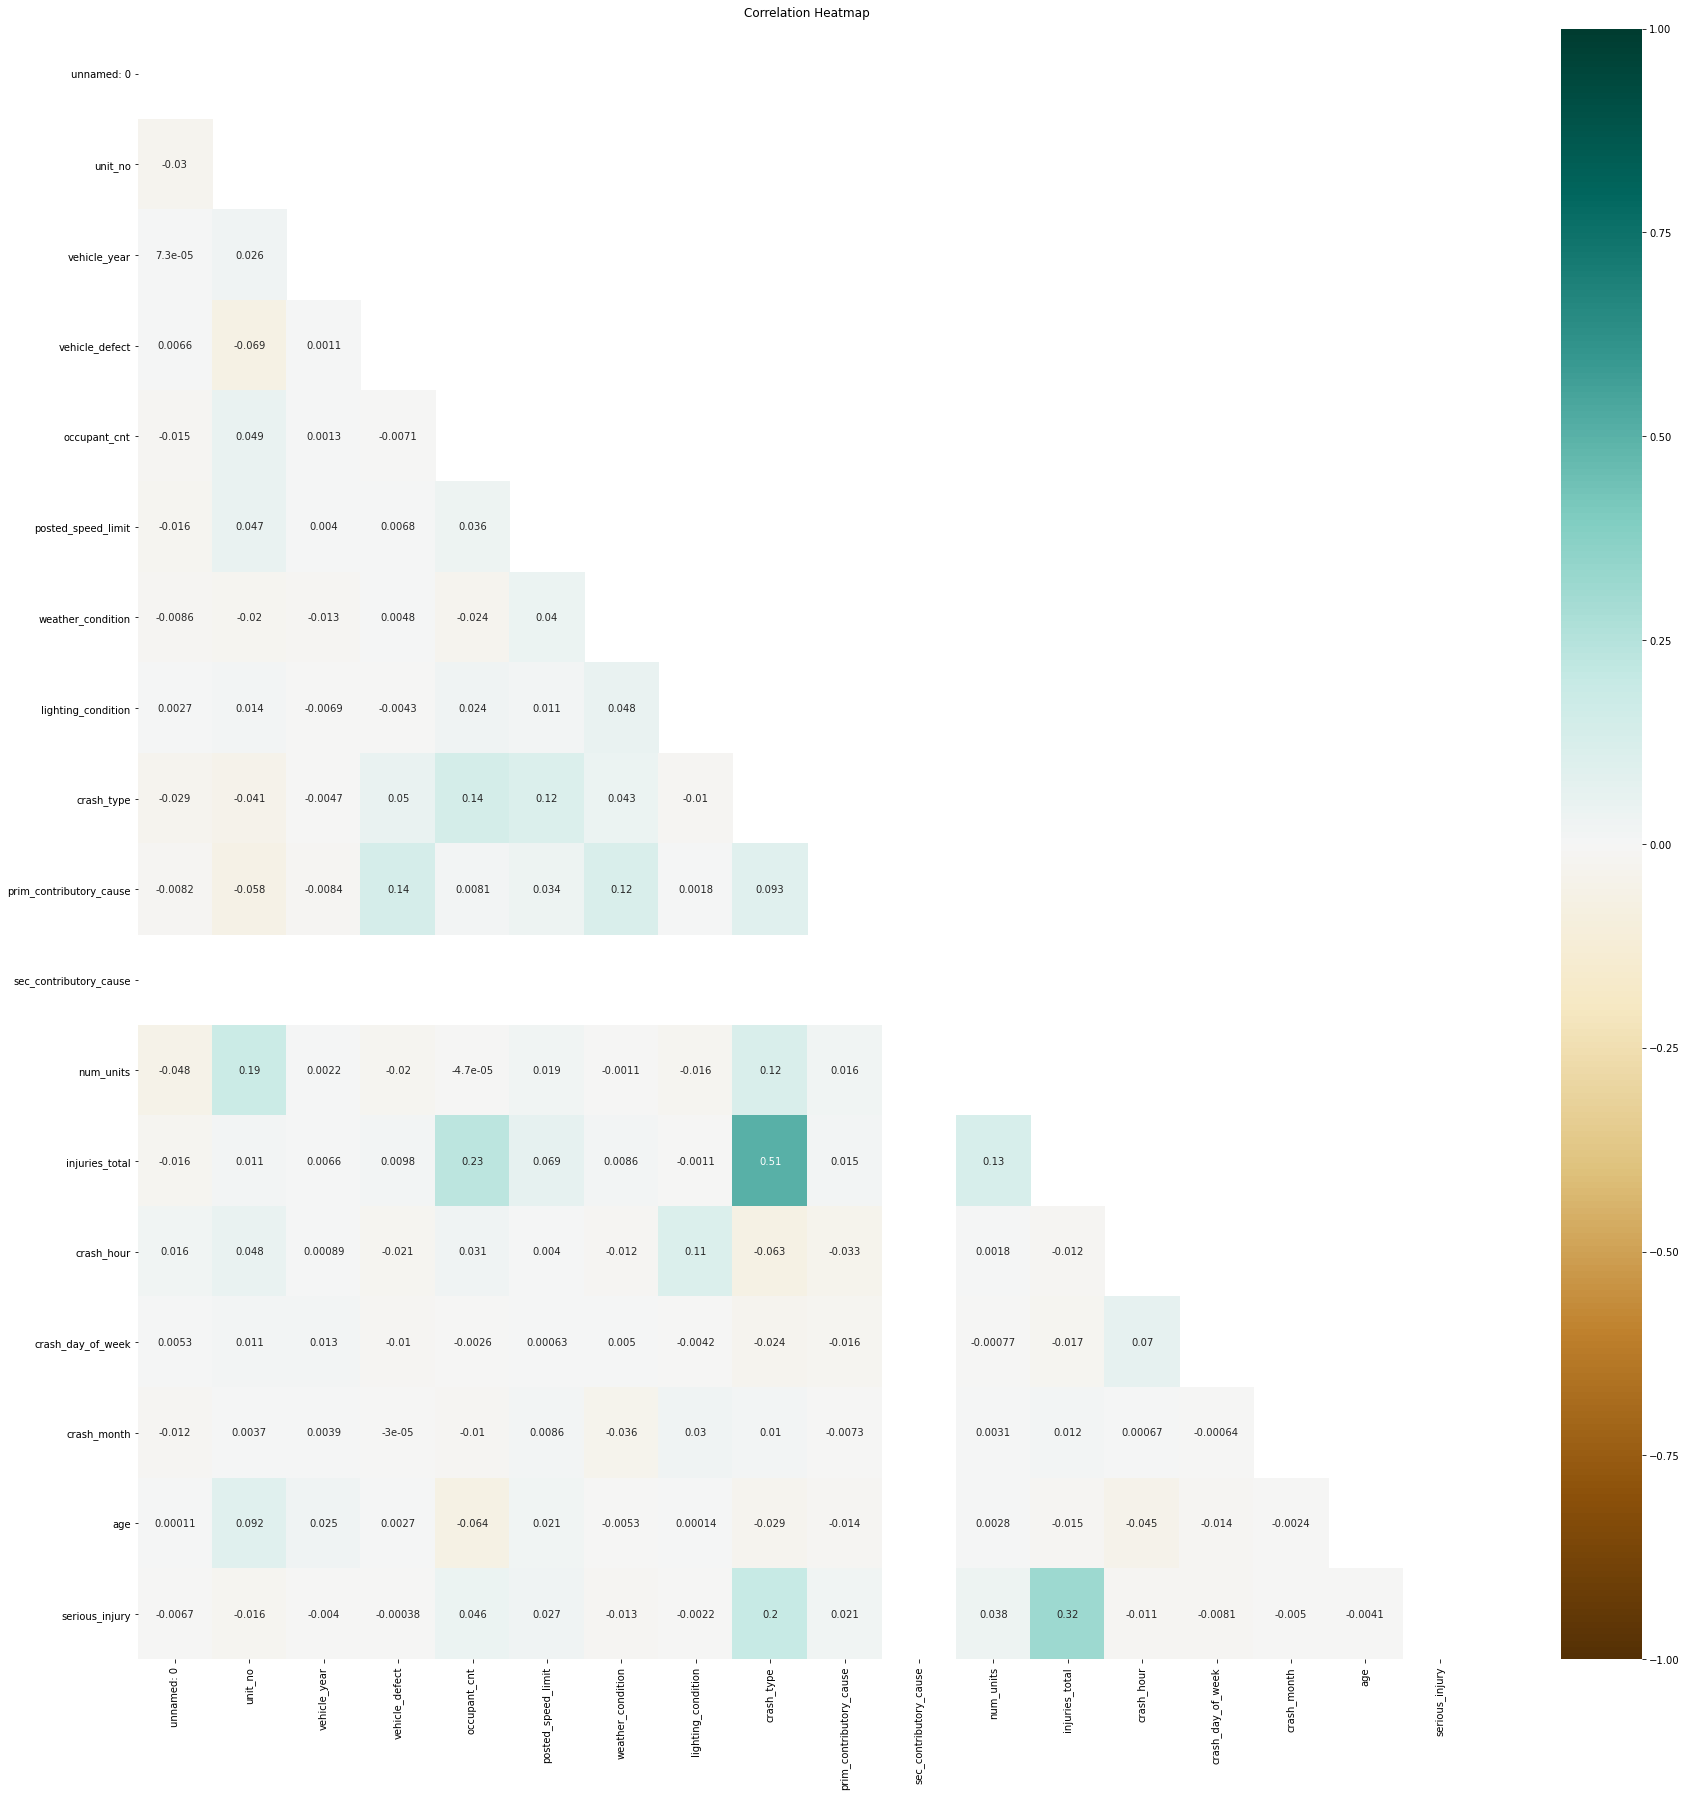

In [187]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Decision Tree

In [200]:
#Train-Test Split

X = df_accidents.select_dtypes(exclude=['object'])
X = X.drop(columns='serious_injury')
X = X.drop(columns=['unnamed: 0', 'crash_date', 'unit_no', 'num_units', 'injuries_total'])
y = df_accidents['serious_injury']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [201]:
#examine data balance 
y.value_counts()

0    18321
1      445
Name: serious_injury, dtype: int64

In [202]:
X

,vehicle_year,vehicle_defect,occupant_cnt,posted_speed_limit,weather_condition,lighting_condition,crash_type,prim_contributory_cause,sec_contributory_cause,crash_hour,crash_day_of_week,crash_month,age
44,2014.0,0,2.0,30,0,0,0,0,0,21,7,8,21.0
51,2006.0,0,1.0,35,0,0,1,0,0,14,3,11,18.0
73,2013.0,0,1.0,35,0,0,1,1,0,8,1,9,19.0
79,2009.0,0,3.0,30,0,0,1,1,0,13,7,10,21.0
88,2018.0,0,1.0,30,0,0,1,3,0,7,6,10,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378176,2015.0,0,2.0,30,0,0,0,1,0,15,1,7,22.0
378238,2006.0,0,1.0,30,0,0,0,1,0,15,4,9,18.0
378266,2005.0,0,1.0,30,0,0,1,1,0,8,1,12,20.0
378275,1998.0,0,1.0,30,0,0,0,0,0,17,5,3,21.0


In [203]:
tree_clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=100)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=100, random_state=42)

In [204]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.97569987210459
Testing: 0.9780477408354646


In [205]:
feature_used = X.columns

for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)


0.0323520464842197 vehicle_year
0.0 vehicle_defect
0.03457563212220156 occupant_cnt
0.028869987245998208 posted_speed_limit
0.023917818849466713 weather_condition
0.0 lighting_condition
0.6239818693928322 crash_type
0.0 prim_contributory_cause
0.0 sec_contributory_cause
0.11802655450155608 crash_hour
0.010636655159332981 crash_day_of_week
0.06974039882597452 crash_month
0.0578990374184181 age


In [52]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18766 entries, 44 to 378284
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unnamed: 0               18766 non-null  int64         
 1   crash_date               18766 non-null  datetime64[ns]
 2   unit_no                  18766 non-null  int64         
 3   unit_type                18766 non-null  object        
 4   make                     18765 non-null  object        
 5   model                    18762 non-null  object        
 6   lic_plate_state          18223 non-null  object        
 7   vehicle_year             18766 non-null  float64       
 8   vehicle_defect           18766 non-null  int64         
 9   vehicle_type             18766 non-null  object        
 10  vehicle_use              18766 non-null  object        
 11  maneuver                 18766 non-null  object        
 12  occupant_cnt             18766

## Combine Columns into Categories 

In [150]:
#py

## Train Test Split

# Model 1

Justification of Model 1

Conclusions from model 1.

# Model 2

Justification of Model 2

In [206]:
log = LogisticRegression(random_state=101).fit(X_train, y_train)

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [207]:
print('Training:', log.score(X_train, y_train))
print('Testing:', log.score(X_test, y_test))

Training: 0.97569987210459
Testing: 0.9780477408354646


Conclusions from model 2.

# Conclusions 

# Next Steps

# Appendix

In [151]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

unnamed: 0 : 41 , 58
crash_date : 2017-11-14 14:30:00 , 2018-09-23 08:00:00
unit_no : 1 , 2
unit_type : DRIVER , DRIVER
make : TOYOTA MOTOR COMPANY, LTD. , DODGE
model : TOYOTA , CHARGER
lic_plate_state : IL , IL
vehicle_year : 2006.0 , 2013.0
vehicle_defect : 0 , 0
vehicle_type : PASSENGER , PASSENGER
vehicle_use : PERSONAL , PERSONAL
maneuver : STRAIGHT AHEAD , STRAIGHT AHEAD
occupant_cnt : 1.0 , 1.0
first_contact_point : FRONT , FRONT
posted_speed_limit : 35 , 35
traffic_control_device : STOP SIGN/FLASHER , TRAFFIC SIGNAL
device_condition : FUNCTIONING PROPERLY , FUNCTIONING PROPERLY
weather_condition : 800 , 800
lighting_condition : DAYLIGHT , DAYLIGHT
first_crash_type : ANGLE , REAR END
trafficway_type : ONE-WAY , DIVIDED - W/MEDIAN BARRIER
alignment : STRAIGHT AND LEVEL , STRAIGHT ON GRADE
roadway_surface_cond : DRY , DRY
road_defect : UNKNOWN , NO DEFECTS
report_type : NOT ON SCENE (DESK REPORT) , ON SCENE
crash_type : 1 , 1
damage : OVER $1,500 , OVER $1,500
date_police_notifie